In [1]:
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path)

/root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered/versions/2


# Retinal Image Classification

## Diabetic Retinopathy

Identify the signs of diabetic retinopathy in eye images.

### 1. Data Preparation and Image Loaders

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image

df = pd.read_csv(os.path.join(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path, 'train.csv'))

root_dir = os.path.join(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path, 'gaussian_filtered_images', 'gaussian_filtered_images')

label_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

df['label_folder'] = df['diagnosis'].map(label_mapping)

train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['diagnosis'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['diagnosis'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0] + ".png"
        diagnosis = self.df.iloc[idx, 1]
        label_folder = label_mapping[diagnosis]

        img_path = os.path.join(self.root_dir, label_folder, image_id)

        if not os.path.isfile(img_path):
            print(f"File not found: {img_path}")
            raise FileNotFoundError(f"File not found: {img_path}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, diagnosis

# Create dataset instances
train_dataset = DiabeticRetinopathyDataset(train, root_dir, transform)
val_dataset = DiabeticRetinopathyDataset(val, root_dir, transform)
test_dataset = DiabeticRetinopathyDataset(test, root_dir, transform)

# Function to convert diagnosis labels to binary
def convert_labels_to_binary(dataset):
    binary_labels = []
    for _, diagnosis in dataset:
        binary_label = 0 if diagnosis == 0 else 1
        binary_labels.append(binary_label)
    return binary_labels

# Load train, val, and test data
train_data = [(img, diagnosis) for img, diagnosis in train_dataset]
val_data = [(img, diagnosis) for img, diagnosis in val_dataset]
test_data = [(img, diagnosis) for img, diagnosis in test_dataset]

# Convert labels to binary
train_labels_binary = convert_labels_to_binary(train_data)
val_labels_binary = convert_labels_to_binary(val_data)
test_labels_binary = convert_labels_to_binary(test_data)

# Create DataLoaders using the images and binary labels
train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)], batch_size=64, shuffle=True)
val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)], batch_size=64, shuffle=False)
test_loader = DataLoader([(img, label) for (img, _), label in zip(test_data, test_labels_binary)], batch_size=64, shuffle=False)

### 2. VGGNet and ResNet Architectures

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding='valid')  # input_shape=(224,224,3)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='valid')
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), padding='valid')
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 25 * 25, 32)  # Adjust based on input size after convolutions
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 2)  # Output for 2 classes

    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(dropout_rate=0.15).to(device)

### 3. Training and Evaluation with Metrics

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(val_labels, val_preds)
        prec = precision_score(val_labels, val_preds, average='weighted')
        rec = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')

In [5]:
train_model(model, train_loader, val_loader)

Epoch 1/10, Accuracy: 0.7036, Precision: 0.8088, Recall: 0.7036, F1: 0.6742
Epoch 2/10, Accuracy: 0.9273, Precision: 0.9284, Recall: 0.9273, F1: 0.9273
Epoch 3/10, Accuracy: 0.9182, Precision: 0.9252, Recall: 0.9182, F1: 0.9179
Epoch 4/10, Accuracy: 0.9400, Precision: 0.9422, Recall: 0.9400, F1: 0.9400
Epoch 5/10, Accuracy: 0.9345, Precision: 0.9374, Recall: 0.9345, F1: 0.9345
Epoch 6/10, Accuracy: 0.9400, Precision: 0.9414, Recall: 0.9400, F1: 0.9400
Epoch 7/10, Accuracy: 0.9400, Precision: 0.9422, Recall: 0.9400, F1: 0.9400
Epoch 8/10, Accuracy: 0.9436, Precision: 0.9454, Recall: 0.9436, F1: 0.9436
Epoch 9/10, Accuracy: 0.9436, Precision: 0.9450, Recall: 0.9436, F1: 0.9436
Epoch 10/10, Accuracy: 0.9400, Precision: 0.9414, Recall: 0.9400, F1: 0.9400


### 4. Confusion matrix and Visualization

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

### 5. Hyperparameter tuning

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from itertools import product

learning_rates = [1e-4, 1e-3]
batch_sizes = [32, 64]
num_epochs_list = [10, 15]
dropout_rates = [0.1, 0.2]

def train_with_hyperparameters(learning_rate, batch_size, num_epochs, dropout_rate):
    model = CustomCNN(dropout_rate).to(device)
    train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)],
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)],
                            batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(val_labels, val_preds)
    return acc

best_acc = 0
best_params = {}

for learning_rate, batch_size, num_epochs, dropout_rate in product(learning_rates, batch_sizes, num_epochs_list, dropout_rates):
    print(f'Testing learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}, dropout_rate={dropout_rate}')
    acc = train_with_hyperparameters(learning_rate, batch_size, num_epochs, dropout_rate)
    print(f'Accuracy: {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        best_params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'dropout_rate': dropout_rate
        }

print(f'Best Accuracy: {best_acc:.4f} with parameters: {best_params}')

Testing learning_rate=0.0001, batch_size=32, num_epochs=10, dropout_rate=0.1
Accuracy: 0.9236
Testing learning_rate=0.0001, batch_size=32, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9473
Testing learning_rate=0.0001, batch_size=32, num_epochs=15, dropout_rate=0.1
Accuracy: 0.9455
Testing learning_rate=0.0001, batch_size=32, num_epochs=15, dropout_rate=0.2
Accuracy: 0.9418
Testing learning_rate=0.0001, batch_size=64, num_epochs=10, dropout_rate=0.1
Accuracy: 0.9509
Testing learning_rate=0.0001, batch_size=64, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9564
Testing learning_rate=0.0001, batch_size=64, num_epochs=15, dropout_rate=0.1
Accuracy: 0.9418
Testing learning_rate=0.0001, batch_size=64, num_epochs=15, dropout_rate=0.2
Accuracy: 0.9418
Testing learning_rate=0.001, batch_size=32, num_epochs=10, dropout_rate=0.1
Accuracy: 0.7855
Testing learning_rate=0.001, batch_size=32, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9291
Testing learning_rate=0.001, batch_size=32, num_epochs=15, dro

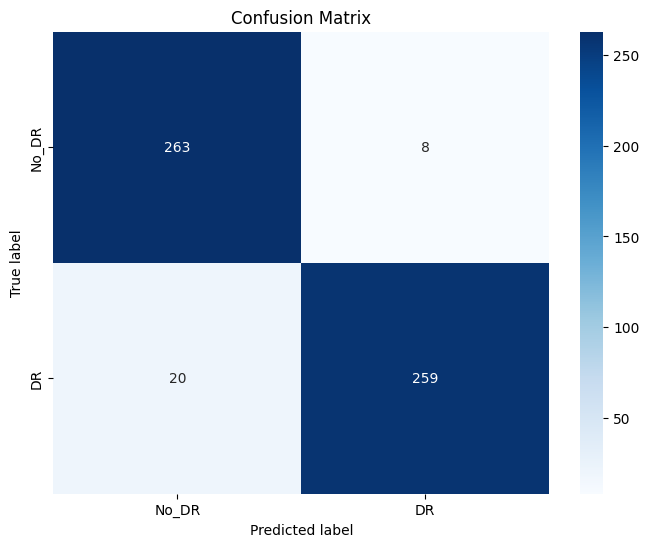

Final Validation Accuracy: 0.9491
Model saved to diabetic_retinopathy_model.pth


In [8]:
def train_final_model(best_params):
    model = CustomCNN(best_params['dropout_rate']).to(device)
    train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)],
                              batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)],
                            batch_size=best_params['batch_size'], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    for epoch in range(best_params['num_epochs']):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(val_labels, val_preds)
    plot_confusion_matrix(val_labels, val_preds, ["No_DR", "DR"])
    print(f'Final Validation Accuracy: {acc:.4f}')

    model_path = 'diabetic_retinopathy_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

train_final_model(best_params)